In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import scanpy as sc
import decoupler as dc
import pandas as pd
import numpy as np
from loguru import logger

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('/home/mowp/workspace/mowp_scripts/tools')

import os
os.environ['R_HOME'] = '/home/mowp/mambaforge/envs/sc/lib/R'

import sctk

In [19]:
import liana as li
import plotnine as p9
from typing import Union, Literal
from liana.method import cellphonedb

In [6]:
from liana.plotting._common import _prep_liana_res, _filter_by, _get_top_n, _inverse_scores

def prep_liana_res(
    adata, uns_key: str, 
    source_labels: list = None, target_labels: list = None, 
    ligand_complex: list = None, receptor_complex: list = None,
    filter_fun = None,
    top_n: int = None, 
    orderby: str = None, orderby_ascending: bool = None, orderby_absolute: bool = None,
    inverse_key: list = None  # inverse_key=['cellphone_pvals']
    ):
    """
    Prepare Liana results for plotting.

    Parameters
    ----------
    adata : anndata.AnnData
        Annotated data matrix.
    uns_key : str
        Key in `adata.uns` where Liana results are stored.
    source_labels : list of str, optional
        List of source cell type labels.
    target_labels : list of str, optional
        List of target cell type labels.
    ligand_complex : str, optional
        Name of the ligand complex column in Liana results.
    receptor_complex : str, optional
        Name of the receptor complex column in Liana results.
    filter_fun : callable, optional
        Function to filter Liana results.
    top_n : int, optional
        Number of top interactions to select.
    orderby : str, optional
        Column name to order interactions by.
    orderby_ascending : bool, optional
        Whether to order interactions in ascending order.
    orderby_absolute : bool, optional
        Whether to order interactions by absolute value.
    inverse_key : list of str, optional
        List of column names to apply inverse scores to.

    Returns
    -------
    liana_res : pandas.DataFrame
        Filtered and sorted Liana results.

    """
    liana_res = _prep_liana_res(
        adata=adata,
        source_labels=source_labels,
        target_labels=target_labels,
        ligand_complex=ligand_complex,
        receptor_complex=receptor_complex,
        uns_key=uns_key)

    liana_res = _filter_by(liana_res, filter_fun=filter_fun)
    liana_res = _get_top_n(liana_res, top_n, orderby, orderby_ascending, orderby_absolute)

    if inverse_key is not None:
        if isinstance(inverse_key, str):
            inverse_key = [inverse_key]
        for key in inverse_key:
            liana_res[key] = _inverse_scores(liana_res[key])
    
    return liana_res

In [13]:
# Read in
adata = sc.read_h5ad(
    "/data/user/mowp/workspace/single_cell_analysis/single-cell-best-practics/dataset/kang_counts_25k.h5ad", 
    # backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata

# Store the counts for later use
adata.layers["counts"] = adata.X.copy()

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
# Store the counts for later use
adata.layers["counts"] = adata.X.copy()
# Rename label to condition, replicate to patient
adata.obs = adata.obs.rename({"label": "condition", "replicate": "patient"}, axis=1)
# assign sample
adata.obs["sample"] = (
    adata.obs["condition"].astype("str") + "&" + adata.obs["patient"].astype("str")
)

In [16]:
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [17]:
adata = adata[adata.obs["condition"] == "stim"].copy()
adata

AnnData object with n_obs × n_vars = 12301 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

... storing 'sample' as categorical


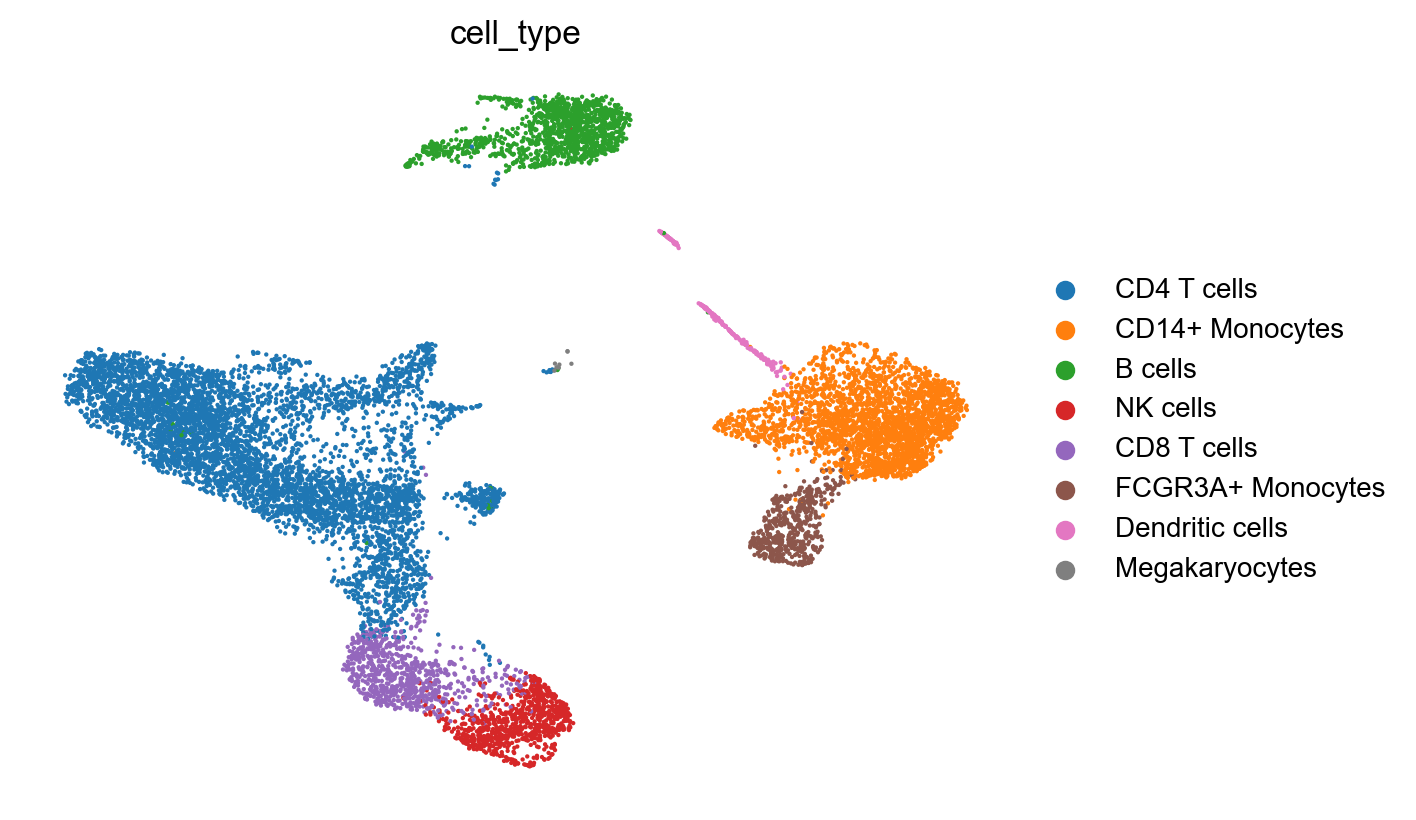

In [18]:
sc.pl.umap(adata, color=["cell_type"], frameon=False)

In [20]:
cellphonedb(
    adata, groupby='cell_type', expr_prop=0.1, resource_name='consensus', 
    use_raw=False, verbose=True, key_added='cpdb_res', n_jobs=8)

Using `.X`!
Converting to sparse csr matrix!
227 features of mat are empty, they will be removed.
Using resource `consensus`.
0.46 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 12301 samples and 892 features


100%|██████████| 1000/1000 [00:06<00:00, 149.95it/s]


In [21]:
liana_res = prep_liana_res(
    adata, uns_key='cpdb_res',
    ligand_complex = None,
    receptor_complex = None,
    filter_fun = lambda x: x['cellphone_pvals'] < 0.01,
)

In [22]:
liana_res.head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals,interaction
721,B2M,B2M,4.431647,1.0,KLRD1,KLRD1,0.591819,0.537747,CD8 T cells,NK cells,2.511733,0.0,B2M -> KLRD1
697,B2M,B2M,4.359549,1.0,KLRD1,KLRD1,0.591819,0.537747,NK cells,NK cells,2.475684,0.0,B2M -> KLRD1
987,B2M,B2M,4.431647,1.0,KLRD1,KLRD1,0.419571,0.406173,CD8 T cells,CD8 T cells,2.425609,0.0,B2M -> KLRD1
959,B2M,B2M,4.359549,1.0,KLRD1,KLRD1,0.419571,0.406173,NK cells,CD8 T cells,2.389560,0.0,B2M -> KLRD1
724,B2M,B2M,4.431647,1.0,KLRC1,KLRC1,0.274590,0.271777,CD8 T cells,NK cells,2.353119,0.0,B2M -> KLRC1


<Axes: >

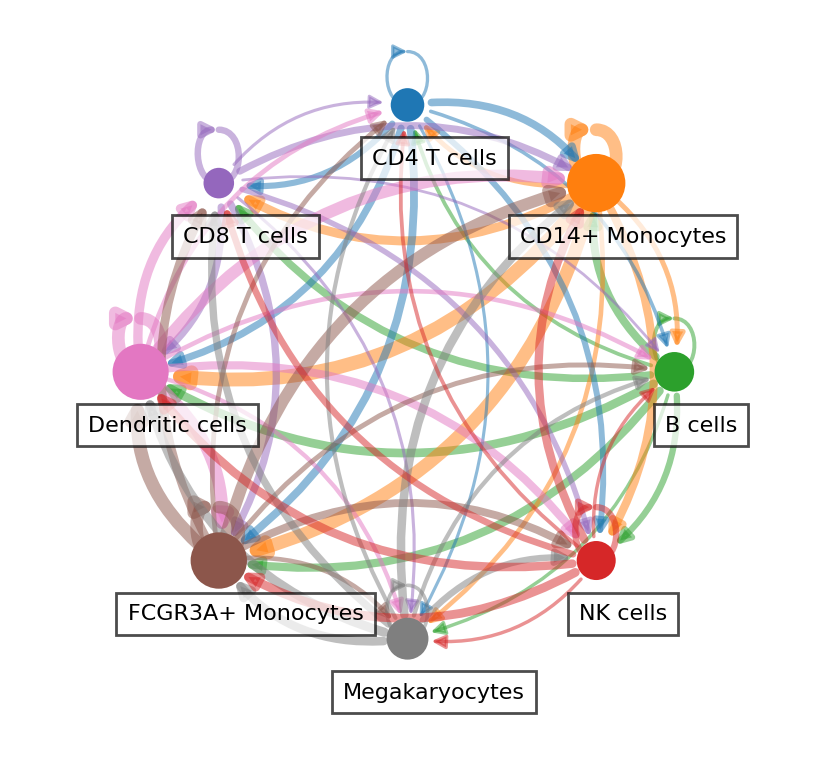

In [46]:
sctk.pl.circle_plot(
    adata,
    liana_res
)

<Axes: >

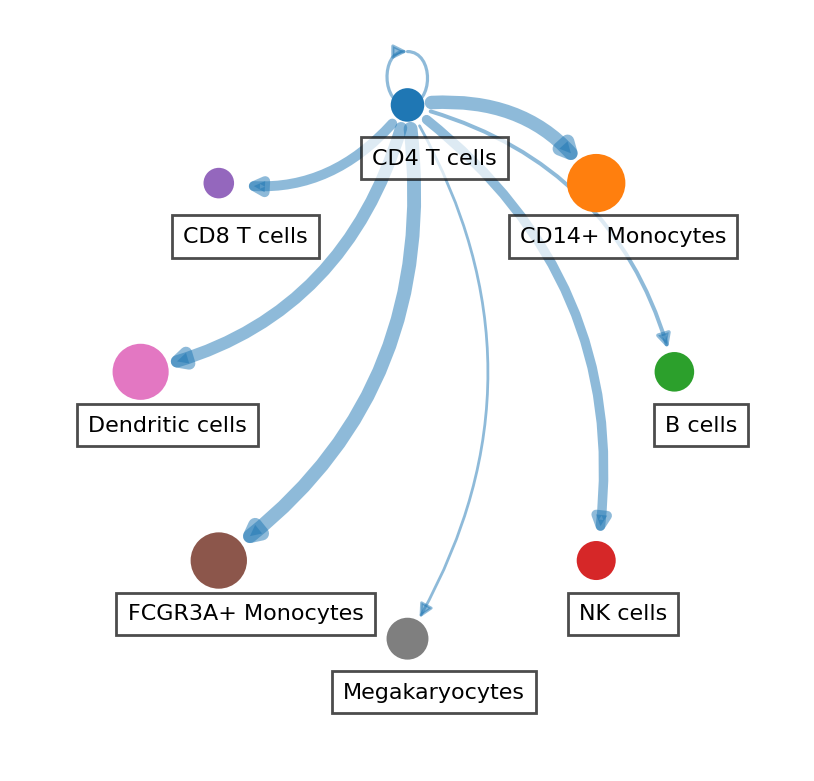

In [47]:
sctk.pl.circle_plot(
    adata,
    liana_res,
    source_cell_type = 'CD4 T cells'
)

In [49]:
import session_info

session_info.show()